In [29]:
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')


from data_downloader import DataDownloader
from var_model import VAR
from dice_model import DiceModel

In [30]:
downloader = DataDownloader()

assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2019-01-01'
end_date = '2023-12-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, end_date=end_date,
                                                                      assets=assets, benchmark=benchmark)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [31]:
asset_prices.head()

,AAPL,BEP,FSLR,GOOG,IBM,NEE,NVDA,TSLA,VWDRY
Date,,,,,,,,,
2019-01-02,37.750095,11.020565,42.560001,52.164394,83.947754,37.104198,3.378323,20.674667,4.908936
2019-01-03,33.989891,11.246674,43.439999,50.678543,82.271858,37.012440,3.174215,20.024000,4.858706
2019-01-04,35.440903,11.606770,46.320000,53.404346,85.485214,37.694092,3.377579,21.179333,4.883821
2019-01-07,35.362015,11.707261,45.790001,53.288631,86.089981,37.639473,3.556390,22.330667,4.910868
2019-01-08,36.036121,11.778440,46.230000,53.682163,87.314117,37.914753,3.467852,22.356667,4.934050


In [32]:
# Cargar archivos CSV
temperature = pd.read_csv('Data/Temperature.csv')
drought = pd.read_csv('Data/Drought_Severity.csv')

# Cargar archivo XLSX
co2_emission = pd.read_excel('Data/CO2_Emissions.xlsx', skiprows=10).drop(index=0)
co2_emission = co2_emission[["Month",
                             "Coal, Including Coal Coke Net Imports, CO2 Emissions",
                             "Natural Gas, Excluding Supplemental Gaseous Fuels, CO2 Emissions", 
                             "Petroleum, Excluding Biofuels, CO2 Emissions", 
                             "Total Energy CO2 Emissions"]]
co2_emission = co2_emission.rename(columns={
    "Month": "Date",
    "Coal, Including Coal Coke Net Imports, CO2 Emissions": "Coal",
    "Natural Gas, Excluding Supplemental Gaseous Fuels, CO2 Emissions": "Natural Gas",
    "Petroleum, Excluding Biofuels, CO2 Emissions": "Petroleum",
    "Total Energy CO2 Emissions": "Total CO2 Emissions"
})

co2_emission

,Date,Coal,Natural Gas,Petroleum,Total CO2 Emissions
1,1973-01-01,109.552,125.557,218.972,454.082
2,1973-02-01,98.833,113.75,202.519,415.102
3,1973-03-01,98.483,107.7,201.245,407.428
4,1973-04-01,94.15,97.838,176.222,368.21
5,1973-05-01,95.424,92.039,188.57,376.032
...,...,...,...,...,...
613,2024-01-01,83.031,200.228,183.995,467.886
614,2024-02-01,53.298,160.596,173.319,387.805
615,2024-03-01,46.63,150.845,185.759,383.866
616,2024-04-01,44.366,129.155,184.741,358.875


In [33]:
# Function to drop a or multiple columns from a dataframe
def drop_columns(df, columns):
    df = df.drop(columns=columns)   
    return df

# Function to rename columns in a dataframe
def rename_columns(df, columns):
    df = df.rename(columns=columns)
    return df

# Drop the 'Average surface temperature.1', 'Entity', 'year'  columns from the temperature dataframe and also index
temperature = drop_columns(temperature, ['Average surface temperature.1','Code', 'Entity', 'year'])

# Rename the columns in the temperature dataframe 
temperature = rename_columns(temperature, {'Day': 'Date',
                             'Average surface temperature': 'Temperature'})
temperature['Date'] = pd.to_datetime(temperature['Date'], format='%d/%m/%y', errors='coerce')
temperature['Date'] = temperature['Date'].apply(lambda x: x.replace(year=x.year - 100) if x.year >= 2025 else x)
temperature = temperature[(temperature['Date'] >= '1940-01-01') & (temperature['Date'] <= '2024-12-31')]
temperature['Date'] = temperature['Date'].apply(lambda x: x.replace(day=1))

temperature

,Date,Temperature
0,1940-01-01,-7.278521
1,1940-02-01,-3.639929
2,1940-03-01,0.422743
3,1940-04-01,6.756010
4,1940-05-01,13.282525
...,...,...
1011,2024-04-01,9.773721
1012,2024-05-01,14.883865
1013,2024-06-01,20.794046
1014,2024-07-01,22.566105


In [34]:
# Eliminar columnas innecesarias
if 'Code' in drought.columns:
    drought = drought.drop(columns=['Code'])
if 'Name' in drought.columns:
    drought = drought.drop(columns=['Name'])

drought = rename_columns(drought, {'MapDate': 'Date'})
drought['Date'] = pd.to_datetime(drought['Date'], format='%Y%m%d')

# Extraer el año y mes
drought['Year'] = drought['Date'].dt.year
drought['Month'] = drought['Date'].dt.month

# Asegurarte de que la columna 'DSCI' sea numérica y eliminar NaNs
drought['DSCI'] = pd.to_numeric(drought['DSCI'], errors='coerce')

# Agrupar por año y mes y calcular el promedio
monthly_avg = drought.groupby(['Year', 'Month'])['DSCI'].mean().reset_index()
monthly_avg['Month'] = monthly_avg['Month'].fillna(0).astype(int)

# Formatear la fecha como aaaa/mm/01
monthly_avg['Date'] = monthly_avg.apply(lambda row: f"{int(row['Year'])}-{int(row['Month']):02d}-01", axis=1)
drought['Date'] = pd.to_datetime(drought['Date'], format='%Y%m%d')
drought = monthly_avg[['Date', 'DSCI']]

drought

,Date,DSCI
0,2014-12-01,104.000000
1,2015-01-01,103.250000
2,2015-02-01,111.250000
3,2015-03-01,117.200000
4,2015-04-01,125.250000
...,...,...
113,2024-05-01,49.000000
114,2024-06-01,51.500000
115,2024-07-01,75.000000
116,2024-08-01,89.250000


In [35]:
# Asegurarse de que la columna 'Date' en todos los dataframes esté en formato datetime
temperature['Date'] = pd.to_datetime(temperature['Date'], errors='coerce')
drought['Date'] = pd.to_datetime(drought['Date'], errors='coerce')
co2_emission['Date'] = pd.to_datetime(co2_emission['Date'], errors='coerce')

# Realizar la fusión de los dataframes en la columna 'Date'
data = pd.merge(temperature, drought, on='Date', how='inner')
data = pd.merge(data, co2_emission, on='Date', how='inner')

data

,Date,Temperature,DSCI,Coal,Natural Gas,Petroleum,Total CO2 Emissions
0,2014-12-01,0.406236,104.00,137.141,145.036,193.691,476.849
1,2015-01-01,-2.130782,103.25,142.702,169.461,193.348,506.487
2,2015-02-01,-1.558285,111.25,134.174,159.167,177.92,472.142
3,2015-03-01,4.647972,117.20,118.251,140.804,195.701,455.732
4,2015-04-01,9.749160,125.25,98.996,108.871,187.169,395.98
...,...,...,...,...,...,...,...
109,2024-01-01,-2.727223,98.80,83.031,200.228,183.995,467.886
110,2024-02-01,1.957276,72.75,53.298,160.596,173.319,387.805
111,2024-03-01,4.290544,74.25,46.63,150.845,185.759,383.866
112,2024-04-01,9.773721,63.00,44.366,129.155,184.741,358.875


In [36]:
# Function to calculate the monthly returns of a dataframe
def calculate_monthly_returns(df):
    if 'Date' in df.columns:
        df = df.set_index('Date')
    
    # Resample to monthly frequency and get the last value of each month
    df = df.resample('M').last()
    
    # Calculate percentage change (returns) and drop NaN values
    df = df.pct_change().dropna()
    
    return df

# Example returns calculation
asset_returns = calculate_monthly_returns(asset_prices)
benchmark_returns = calculate_monthly_returns(benchmark_prices)

# Reset index to turn the Date back into a column
asset_returns = asset_returns.reset_index()

# Modify the Date column to set the day to the 1st of each month
asset_returns['Date'] = asset_returns['Date'].apply(lambda x: x.replace(day=1))

# Display the first rows of the asset returns
asset_returns.head()


,Date,AAPL,BEP,FSLR,GOOG,IBM,NEE,NVDA,TSLA,VWDRY
0,2019-02-01,0.044776,0.061304,0.038743,0.003180,0.039573,0.055844,0.074219,0.041886,0.002888
1,2019-03-01,0.097026,0.061815,0.005519,0.047673,0.021501,0.029832,0.164009,-0.125109,0.010439
2,2019-04-01,0.056436,-0.013459,0.164459,0.012929,-0.005882,0.005794,0.008019,-0.147109,0.089232
3,2019-05-01,-0.124213,0.021257,-0.056720,-0.071394,-0.083920,0.025834,-0.250748,-0.224266,-0.098377
4,2019-06-01,0.130519,0.074557,0.131633,-0.020587,0.085912,0.033550,0.212388,0.206848,0.058413


<Axes: title={'center': 'Asset Returns'}, xlabel='Date'>

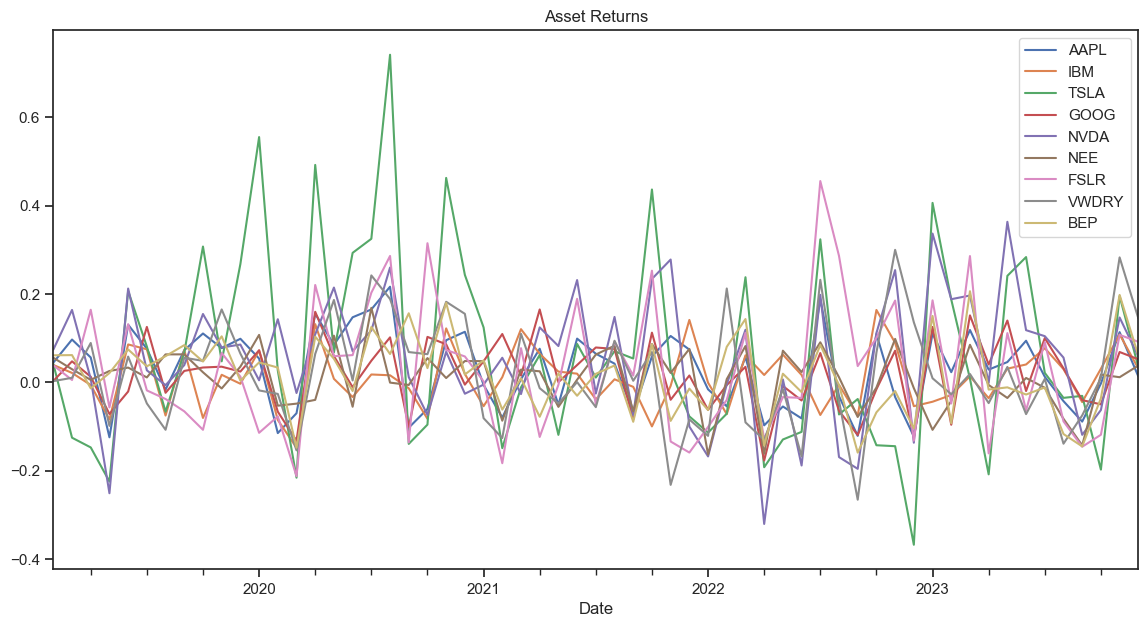

In [37]:
asset_returns.plot(x='Date', y=assets, figsize=(14, 7), title='Asset Returns')